In [18]:
## This notebook is for testing trained baseline model on both test and real data

In [1]:
# auto-load when code changes outside
%load_ext autoreload
%autoreload 2
%load_ext pyinstrument

import sys
sys.path.insert(0,'..')


In [2]:
#imports 
import os
import nltk
import spacy
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.onnx as onnx
import torch.optim as optim
import torchvision.models as models

from src.baseline.vocabulary import Vocabulary
from src.utils import print_time, list_of_tensors_to_numpy_arr, plot_image, plot_im
from src.accuracy import Accuracy
from src.baseline.coa_model import get_new_model,load_model, train_validate_test_split, init_testing_model, test_model, test_rand_image, get_training_mean_std


In [3]:
!export CUDA_VISIBLE_DEVICES=0
!export CUDA_LAUNCH_BLOCKING=1

In [4]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

device

device(type='cuda', index=0)

In [5]:
# torch.cuda.get_device_name(0)

In [7]:
# Hyperparams

embed_size=300
vocab_size = 36
attention_dim=256
encoder_dim=2048
decoder_dim=512
learning_rate = 3e-4
drop_prob=0.3
ignored_idx = 0

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

hyper_params = {'embed_size': embed_size,
                'attention_dim': attention_dim,
                'encoder_dim': encoder_dim,
                'decoder_dim': decoder_dim,
                'vocab_size': vocab_size
              }


## Train/Evaluate a baseline model on the synthetic test data the loaded model on synthetic data

In [8]:
# data_location = '/home/space/datasets/COA/generated-data-api'
# data_location =  '/home/space/datasets/COA/generated-data-api-small'
data_location =  '/home/space/datasets/COA/generated-data-api-large'

# data_location =  '../baseline-gen-data/small'
root_folder_images = data_location + '/images'

test_caption_file = data_location + '/test_captions_psumsq.txt'
df = pd.read_csv(test_caption_file)

print("There are {} test images".format(len(df)))

There are 235585 test images


In [9]:
# this model is trained on the largest dataset
# model_path = '/home/space/datasets/COA/models/baseline/attention_model-qsub-06.08.2022-12:51:39.pth'

# EXP_FOLDER_PATH = '../experiments/'
EXP_FOLDER_PATH = '/home/space/datasets/COA/experiments/' 
run_path   = EXP_FOLDER_PATH + 'run-06-22-2022-07:57:31/'
model_file = 'baseline-model-06-25-2022-20:54:47.pth'

model, optimizer, loss,criterion = load_model(run_path+model_file, 
                                    hyper_params, 
                                    learning_rate,
                                    drop_prob, 
                                    ignored_idx)


In [10]:
!export CUDA_LAUNCH_BLOCKING=1
!export CUDA_VISIBLE_DEVICES=2

In [11]:
# BATCH_SIZE = 5
NUM_WORKER = 2 #### this needs multi-core
freq_threshold = 5
batch_size = 256

# 30 minutes to create those, as it's baseline, i ran it several times and it's the same
vocab = Vocabulary(freq_threshold)
vocab.stoi = {'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3, 'lion': 4, 'rampant': 5, 'passt': 6, 'guard': 7, 'head': 8, 'lions': 9, 'cross': 10, 'moline': 11, 'patonce': 12, 'eagle': 13, 'doubleheaded': 14, 'eagles': 15, 'a': 16, 'b': 17, 'o': 18, 's': 19, 'g': 20, 'e': 21, 'v': 22, '1': 23, '2': 24, '3': 25, '4': 26, '5': 27, '6': 28, '7': 29, '8': 30, '9': 31, '10': 32, '11': 33, 'border': 34, '&': 35}
vocab.itos = {0: '<PAD>', 1: '<SOS>', 2: '<EOS>', 3: '<UNK>', 4: 'lion', 5: 'rampant', 6: 'passt', 7: 'guard', 8: 'head', 9: 'lions', 10: 'cross', 11: 'moline', 12: 'patonce', 13: 'eagle', 14: 'doubleheaded', 15: 'eagles', 16: 'a', 17: 'b', 18: 'o', 19: 's', 20: 'g', 21: 'e', 22: 'v', 23: '1', 24: '2', 25: '3', 26: '4', 27: '5', 28: '6', 29: '7', 30: '8', 31: '9', 32: '10', 33: '11', 34: 'border', 35: '&'}


### Get the mean and std 
This was calculated and saved in training phase in files

In [12]:
mean, std = get_training_mean_std(run_path)

mean=0.28080669045448303, std=0.3387645483016968


### Init the test model

In [14]:
test_loader, test_dataset = init_testing_model(test_caption_file, 
                                               root_folder_images, 
                                               mean, std,
                                               NUM_WORKER,
                                               vocab,
                                               batch_size, 
                                               device, 
                                               pin_memory=False)


In [ ]:
test_losses, accuracy_test_list, acc_test_score, test_loss = test_model(model, 
                                                                        criterion,
                                                                        test_loader, 
                                                                        test_dataset, 
                                                                        vocab_size, 
                                                                        device,
                                                                        run_path,
                                                                        False)

Index 1 does not exist in item, seems like predicted less than Ground truth
Index 2 does not exist in item, seems like predicted less than Ground truth
Test Acuuracy (in progress): 0.610000

Index 1 does not exist in item, seems like predicted less than Ground truth
Index 2 does not exist in item, seems like predicted less than Ground truth
Test Acuuracy (in progress): 0.360000

Index 1 does not exist in item, seems like predicted less than Ground truth
Index 2 does not exist in item, seems like predicted less than Ground truth
Test Acuuracy (in progress): 0.665000

Index 1 does not exist in item, seems like predicted less than Ground truth
Index 2 does not exist in item, seems like predicted less than Ground truth
Test Acuuracy (in progress): 0.665000

Index 1 does not exist in item, seems like predicted less than Ground truth
Index 2 does not exist in item, seems like predicted less than Ground truth
Test Acuuracy (in progress): 0.665000

Index 1 does not exist in item, seems like pr

Index 1 does not exist in item, seems like predicted less than Ground truth
Index 2 does not exist in item, seems like predicted less than Ground truth
Test Acuuracy (in progress): 0.665000

Index 1 does not exist in item, seems like predicted less than Ground truth
Index 2 does not exist in item, seems like predicted less than Ground truth
Test Acuuracy (in progress): 0.665000

Index 1 does not exist in item, seems like predicted less than Ground truth
Index 2 does not exist in item, seems like predicted less than Ground truth
Test Acuuracy (in progress): 0.665000

Index 1 does not exist in item, seems like predicted less than Ground truth
Index 2 does not exist in item, seems like predicted less than Ground truth
Test Acuuracy (in progress): 0.665000

Index 1 does not exist in item, seems like predicted less than Ground truth
Index 2 does not exist in item, seems like predicted less than Ground truth
Test Acuuracy (in progress): 0.665000

Index 1 does not exist in item, seems like pr

Index 1 does not exist in item, seems like predicted less than Ground truth
Index 2 does not exist in item, seems like predicted less than Ground truth
Test Acuuracy (in progress): 0.665000

Index 1 does not exist in item, seems like predicted less than Ground truth
Index 2 does not exist in item, seems like predicted less than Ground truth
Test Acuuracy (in progress): 0.665000

Index 1 does not exist in item, seems like predicted less than Ground truth
Index 2 does not exist in item, seems like predicted less than Ground truth
Test Acuuracy (in progress): 0.665000

Index 1 does not exist in item, seems like predicted less than Ground truth
Index 2 does not exist in item, seems like predicted less than Ground truth
Test Acuuracy (in progress): 0.665000

Index 1 does not exist in item, seems like predicted less than Ground truth
Index 2 does not exist in item, seems like predicted less than Ground truth
Test Acuuracy (in progress): 0.665000

Index 1 does not exist in item, seems like pr

Index 1 does not exist in item, seems like predicted less than Ground truth
Index 2 does not exist in item, seems like predicted less than Ground truth
Test Acuuracy (in progress): 0.610000

Index 1 does not exist in item, seems like predicted less than Ground truth
Index 2 does not exist in item, seems like predicted less than Ground truth
Test Acuuracy (in progress): 0.665000

Index 1 does not exist in item, seems like predicted less than Ground truth
Index 2 does not exist in item, seems like predicted less than Ground truth
Test Acuuracy (in progress): 0.665000

Index 1 does not exist in item, seems like predicted less than Ground truth
Index 2 does not exist in item, seems like predicted less than Ground truth
Test Acuuracy (in progress): 0.665000

Index 1 does not exist in item, seems like predicted less than Ground truth
Index 2 does not exist in item, seems like predicted less than Ground truth
Test Acuuracy (in progress): 0.665000

Index 1 does not exist in item, seems like pr

Index 1 does not exist in item, seems like predicted less than Ground truth
Index 2 does not exist in item, seems like predicted less than Ground truth
Test Acuuracy (in progress): 0.665000

Index 1 does not exist in item, seems like predicted less than Ground truth
Index 2 does not exist in item, seems like predicted less than Ground truth
Test Acuuracy (in progress): 0.665000

Index 1 does not exist in item, seems like predicted less than Ground truth
Index 2 does not exist in item, seems like predicted less than Ground truth
Test Acuuracy (in progress): 0.665000

Index 1 does not exist in item, seems like predicted less than Ground truth
Index 2 does not exist in item, seems like predicted less than Ground truth
Test Acuuracy (in progress): 0.665000

Index 1 does not exist in item, seems like predicted less than Ground truth
Test Acuuracy (in progress): 0.750000

Index 1 does not exist in item, seems like predicted less than Ground truth
Test Acuuracy (in progress): 0.750000

Index 

Index 1 does not exist in item, seems like predicted less than Ground truth
Index 2 does not exist in item, seems like predicted less than Ground truth
Test Acuuracy (in progress): 0.665000

Index 1 does not exist in item, seems like predicted less than Ground truth
Index 2 does not exist in item, seems like predicted less than Ground truth
Test Acuuracy (in progress): 0.665000

Index 1 does not exist in item, seems like predicted less than Ground truth
Index 2 does not exist in item, seems like predicted less than Ground truth
Test Acuuracy (in progress): 0.665000

Index 1 does not exist in item, seems like predicted less than Ground truth
Index 2 does not exist in item, seems like predicted less than Ground truth
Test Acuuracy (in progress): 0.665000

Index 1 does not exist in item, seems like predicted less than Ground truth
Index 2 does not exist in item, seems like predicted less than Ground truth
Test Acuuracy (in progress): 0.665000

Index 1 does not exist in item, seems like pr

Index 1 does not exist in item, seems like predicted less than Ground truth
Index 2 does not exist in item, seems like predicted less than Ground truth
Test Acuuracy (in progress): 0.665000

Index 1 does not exist in item, seems like predicted less than Ground truth
Index 2 does not exist in item, seems like predicted less than Ground truth
Test Acuuracy (in progress): 0.665000

Index 1 does not exist in item, seems like predicted less than Ground truth
Index 2 does not exist in item, seems like predicted less than Ground truth
Test Acuuracy (in progress): 0.665000

Index 1 does not exist in item, seems like predicted less than Ground truth
Index 2 does not exist in item, seems like predicted less than Ground truth
Test Acuuracy (in progress): 0.665000

Index 1 does not exist in item, seems like predicted less than Ground truth
Index 2 does not exist in item, seems like predicted less than Ground truth
Test Acuuracy (in progress): 0.665000

Index 1 does not exist in item, seems like pr

Index 1 does not exist in item, seems like predicted less than Ground truth
Index 2 does not exist in item, seems like predicted less than Ground truth
Test Acuuracy (in progress): 0.665000

Index 1 does not exist in item, seems like predicted less than Ground truth
Index 2 does not exist in item, seems like predicted less than Ground truth
Test Acuuracy (in progress): 0.610000

Index 1 does not exist in item, seems like predicted less than Ground truth
Index 2 does not exist in item, seems like predicted less than Ground truth
Test Acuuracy (in progress): 0.665000

Index 1 does not exist in item, seems like predicted less than Ground truth
Test Acuuracy (in progress): 0.750000

Index 1 does not exist in item, seems like predicted less than Ground truth
Test Acuuracy (in progress): 0.750000

Index 1 does not exist in item, seems like predicted less than Ground truth
Test Acuuracy (in progress): 0.750000

Index 1 does not exist in item, seems like predicted less than Ground truth
Index 

## Visualizing the attentions

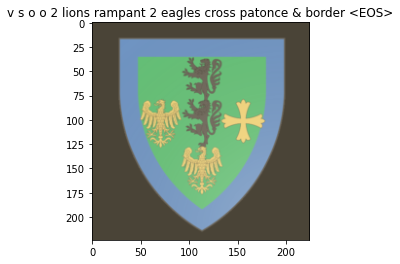

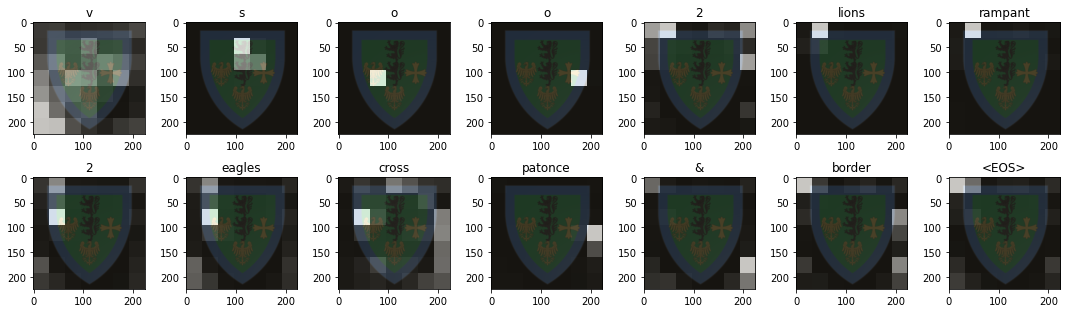

In [20]:
# torch.cuda.empty_cache()
test_rand_image(model,test_dataset,test_loader,device)

# Train/Evaluate a baseline model on the real data

In [52]:
# data_location='/home/salnabulsi/coat-of-arms/data/cropped_coas/out_valid'
# data_location='/home/salnabulsi/coat-of-arms/data/cropped_coas/out'
# data_location='/Users/salnabulsi/tub/coat-of-arms/data/cropped_coas/out_valid'

data_location='/Users/salnabulsi/tub/coat-of-arms/data/cropped_coas/out'
test_caption_file  = data_location + '/test_real_captions_psumsq.txt'
root_folder_images = data_location + '/images/resized'

df = pd.read_csv(test_caption_file)

print("There are {} test images".format(len(df)))

df

There are 269 test images


,image,caption,psum,psum_sq
0,1739_A G cross patonce.jpg,A G cross patonce,724933.00000,557413.50000
1,22117_O B cross patriarchal.jpg,O B cross patriarchal,696633.87500,521719.93750
2,2870_O S lion rampant.jpg,O S lion rampant,370219.71875,231043.09375
3,6870_S O eagle.jpg,S O eagle,840800.62500,661782.93750
4,18746_S A eagle.jpg,S A eagle,880971.43750,601956.43750
...,...,...,...,...
264,398_A S lion rampant.jpg,A S lion rampant,673480.62500,517651.34375
265,249_O G 2 lions passt.jpg,O G 2 lions passt,871046.06250,677358.06250
266,4459_B O eagle.jpg,B O eagle,621500.62500,425808.43750
267,5302_O B cross moline.jpg,O B cross moline,736149.62500,530970.68750


## Get the model

In [64]:
run_path   = '../experiments/run-06.20.2022-13:01:28/'
model_file = 'baseline-model-06.20.2022-13:03:00.pth'

model, optimizer, loss,criterion = load_model(run_path+model_file, 
                                    hyper_params, 
                                    learning_rate,
                                    drop_prob, 
                                    ignored_idx)

In [65]:
!export CUDA_LAUNCH_BLOCKING=1
!export CUDA_VISIBLE_DEVICES=2


In [66]:

# BATCH_SIZE = 5
NUM_WORKER = 2 #### this needs multi-core
freq_threshold = 5
batch_size = 256

# 30 minutes to create those, as it's baseline, i ran it several times and it's the same
vocab = Vocabulary(freq_threshold)
vocab.stoi = {'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3, 'lion': 4, 'rampant': 5, 'passt': 6, 'guard': 7, 'head': 8, 'lions': 9, 'cross': 10, 'moline': 11, 'patonce': 12, 'eagle': 13, 'doubleheaded': 14, 'eagles': 15, 'a': 16, 'b': 17, 'o': 18, 's': 19, 'g': 20, 'e': 21, 'v': 22, '1': 23, '2': 24, '3': 25, '4': 26, '5': 27, '6': 28, '7': 29, '8': 30, '9': 31, '10': 32, '11': 33, 'border': 34, '&': 35}
vocab.itos = {0: '<PAD>', 1: '<SOS>', 2: '<EOS>', 3: '<UNK>', 4: 'lion', 5: 'rampant', 6: 'passt', 7: 'guard', 8: 'head', 9: 'lions', 10: 'cross', 11: 'moline', 12: 'patonce', 13: 'eagle', 14: 'doubleheaded', 15: 'eagles', 16: 'a', 17: 'b', 18: 'o', 19: 's', 20: 'g', 21: 'e', 22: 'v', 23: '1', 24: '2', 25: '3', 26: '4', 27: '5', 28: '6', 29: '7', 30: '8', 31: '9', 32: '10', 33: '11', 34: 'border', 35: '&'}


### Get the mean and std 
This was calculated and saved in training phase in files

In [67]:
mean, std = get_training_mean_std(run_path)

mean=0.3272075951099396, std=0.3805903494358063


In [68]:
test_loader, test_dataset = init_testing_model(test_caption_file, 
                                               root_folder_images,
                                               mean, std,
                                               NUM_WORKER,
                                               vocab,
                                               batch_size,
                                               device, 
                                               pin_memory=False 
                                               ,img_h=600, img_w=620)

# avg size resized (600, 620)


In [69]:

test_model(model, criterion,test_loader, test_dataset, vocab_size, device)


Test Acuuracy (in progress): 0.000000

Test Acuuracy (in progress): 0.000000

Test Loss (final): 0.024951

Test Accuracy (Overall): 0.0%


([tensor(3.3662), tensor(3.3457)], [0.0, 0.0], 0.0, tensor(0.0250))

## Visualizing the attentions


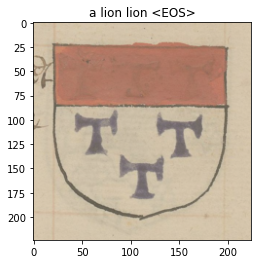

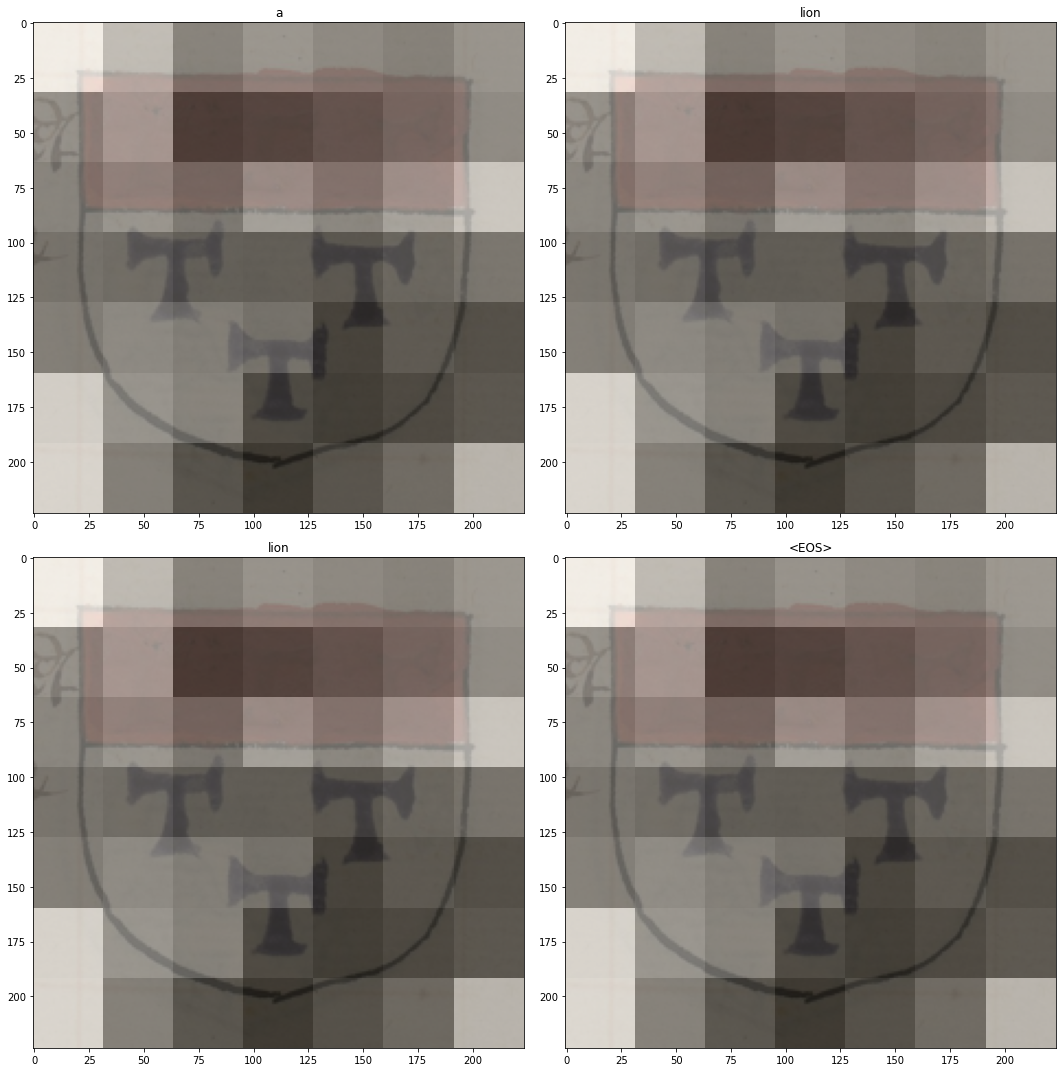

In [70]:
# torch.cuda.empty_cache()
test_rand_image(model,test_dataset,test_loader,device)
